# #############################


# This is part 2 of customer segmentation. This part uses GMM for clustering
# We compare GMM labels with Kmeans on PCAed (PCA = 2) X_train_transformed data
# GMM work appears at the bottom of this notebook

# Customer Segmentation, broad approach, 
    1. Our data set will be the output from Lifetime Value run; that run introduced customr lifespan, and customer lifetime value columns that we might use for segmentation. Plus, this ensures that both our lifetime value and customer segmentation models learned from the same set of customer ids.
    2. We will use pipelines to numericize our features (numeric features, ordinal categorical features, nominal categorical features)
    3. Use K-Means model for clustering
    4. Evaluate clustering performance using metrics
    5. Visualize our clusters using PCA


# SECTION: Library Installations and GPU checks

In [1]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU (Metal) is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available: 1


In [2]:
import tensorflow as tf
import time

# Create a large random tensor
tensor_a = tf.random.normal([1000, 1000])
tensor_b = tf.random.normal([1000, 1000])

# Perform matrix multiplication on GPU
start_time = time.time()
result = tf.matmul(tensor_a, tensor_b)
end_time = time.time()

print("Time taken for matrix multiplication:", end_time - start_time, "seconds")

Time taken for matrix multiplication: 0.005180835723876953 seconds


2025-04-16 17:27:34.569836: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-16 17:27:34.569883: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-16 17:27:34.569890: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-16 17:27:34.569951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-16 17:27:34.569975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# SECTION: Imports and more Libary Installs

In [3]:
#! brew install cmake

In [4]:
#! pip install tensorflow-datasets

In [5]:
# ! pip install scikit-learn

In [6]:
# ! pip install shap


In [7]:
# ! pip install keras-tuner

In [55]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

from scipy import stats
from scipy.stats import boxcox

import keras
import keras_tuner as kt

from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

##especially for clustering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# shap
#import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
#from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(42)
%matplotlib inline

# FILL IN CODE HERE #
RANDOM_SAMPLES_VAL = 500000 #To make computing on local machine, colab palatable, we will use a random sample for the exercise  
RANDOM_STATE = 42

# SECTION: Our helper and utility functions

In [9]:
#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

# SECTION: Data Load

In [10]:
#retail_cls.csv is output from lifetime value run. That run added two calculated columns to our data set: customr lifespan, and customer lifetime value
retail_cust_seg_df =pd.read_csv('retail_clv.csv')

In [11]:
retail_cust_seg_df.shape

(500000, 80)

In [12]:
retail_cust_seg_df.head()

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase,customer_lifespan,customer_lifetime_value
0,459789,44,Male,High,Yes,6,No,Divorced,3,High School,...,Winter,No,13,Yes,High,53,Low,102,4.8,216758.440672
1,967130,51,Other,High,Yes,9,No,Married,2,High School,...,Spring,No,9,Yes,Medium,40,High,154,5.4,10765.518761
2,79799,40,Female,Low,Yes,9,Yes,Single,2,Bachelor's,...,Spring,No,0,Yes,High,5,Low,101,5.4,160387.665202
3,705284,52,Other,Low,Yes,6,Yes,Single,4,High School,...,Winter,Yes,8,Yes,Low,80,High,185,4.8,303726.766564
4,905737,63,Other,Low,No,9,Yes,Divorced,0,Master's,...,Summer,Yes,9,Yes,Medium,96,Low,45,5.4,13730.511388


In [13]:
summarize_dataframe(retail_cust_seg_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,customer_id,int64,0,500000,500000
1,age,int64,0,500000,62
2,gender,object,0,500000,3
3,income_bracket,object,0,500000,3
4,loyalty_program,object,0,500000,2
...,...,...,...,...,...
75,website_visits,int64,0,500000,100
76,social_media_engagement,object,0,500000,3
77,days_since_last_purchase,int64,0,500000,365
78,customer_lifespan,float64,0,500000,10


In [14]:
retail_cust_seg_df.columns

Index(['customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program',
       'membership_years', 'churned', 'marital_status', 'number_of_children',
       'education_level', 'occupation', 'transaction_id', 'transaction_date',
       'product_id', 'product_category', 'quantity', 'unit_price',
       'discount_applied', 'payment_method', 'store_location',
       'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year',
       'avg_purchase_value', 'purchase_frequency', 'last_purchase_date',
       'avg_discount_used', 'preferred_store', 'online_purchases',
       'in_store_purchases', 'avg_items_per_transaction',
       'avg_transaction_value', 'total_returned_items', 'total_returned_value',
       'total_sales', 'total_transactions', 'total_items_purchased',
       'total_discounts_received', 'avg_spent_per_category',
       'max_single_purchase_value', 'min_single_purchase_value',
       'product_name', 'product_brand', 'product_rating',
       'product_review_count', '

In [15]:
# period of data set
retail_cust_seg_df['transaction_date'] = pd.to_datetime(retail_cust_seg_df['transaction_date'])
EARLIEST_DATE = retail_cust_seg_df['transaction_date'].min()
LATEST_DATE   = retail_cust_seg_df['transaction_date'].max()
print(f"Data set spans from {EARLIEST_DATE} TO {LATEST_DATE}")
DATE_OF_ANALYSIS = LATEST_DATE + + pd.Timedelta(days=1) # Our date of analysis is one day after the last day in the data set. Busy day!
print(f"Our date of analysis is: { DATE_OF_ANALYSIS}")

Data set spans from 2020-01-01 00:00:59 TO 2021-12-31 23:56:51
Our date of analysis is: 2022-01-01 23:56:51


In [16]:
#calculate date of last purchase for a customer
jj = retail_cust_seg_df.groupby('customer_id')['transaction_date'].max()

In [17]:
print(f" {type(DATE_OF_ANALYSIS) = }, {type(retail_cust_seg_df['transaction_date']) = }")

 type(DATE_OF_ANALYSIS) = <class 'pandas._libs.tslibs.timestamps.Timestamp'>, type(retail_cust_seg_df['transaction_date']) = <class 'pandas.core.series.Series'>


In [18]:
#Add recency days for each customer, = date of analysis - customer's last transaction date
retail_cust_seg_df['recency'] = (DATE_OF_ANALYSIS - retail_cust_seg_df['transaction_date']).dt.days

In [19]:
#now for frequency score per customer, = number of purchases made by a customer in a period of the data set
#frequency for a customer = number of transaction ids for the customer
jj = retail_cust_seg_df.groupby('customer_id')['transaction_id'].count()

In [20]:
jj.max()

1

In [21]:
retail_cust_seg_df['customer_id'].nunique()

500000

# 
    using transaction id counts for purchase frequency leads to meaningless results, this is because the data set seems to be heavily denormalized. 0.5M rows in data set = 0.5M unique customer ids.
    so, we will use the purchase_frequency column for frequency

In [22]:
retail_cust_seg_df['frequency'] = retail_cust_seg_df['purchase_frequency'].copy()

In [23]:
#similar reasons to assign monetary value to a customer
retail_cust_seg_df['monetary'] = retail_cust_seg_df['total_sales'].copy()

In [24]:
retail_cust_seg_df.columns

Index(['customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program',
       'membership_years', 'churned', 'marital_status', 'number_of_children',
       'education_level', 'occupation', 'transaction_id', 'transaction_date',
       'product_id', 'product_category', 'quantity', 'unit_price',
       'discount_applied', 'payment_method', 'store_location',
       'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year',
       'avg_purchase_value', 'purchase_frequency', 'last_purchase_date',
       'avg_discount_used', 'preferred_store', 'online_purchases',
       'in_store_purchases', 'avg_items_per_transaction',
       'avg_transaction_value', 'total_returned_items', 'total_returned_value',
       'total_sales', 'total_transactions', 'total_items_purchased',
       'total_discounts_received', 'avg_spent_per_category',
       'max_single_purchase_value', 'min_single_purchase_value',
       'product_name', 'product_brand', 'product_rating',
       'product_review_count', '

# Feature Selection - I
        Core Customer Metrics
1.          Recency – Days since the last purchase  
2.          Frequency – Total number of purchases  
3.          Monetary – Average or total amount spent  
4.          Customer Lifetime Value – Estimated value of the customer over time  
5.          Customer Lifespan – Duration between first and most recent purchase  
6.          Total Transactions – Total number of transactions (measures engagement level)  

        Loyalty and Commitment Indicators
7.          Loyalty Program – Brand commitment indicator  
        
        Price Sensitivity
8.          Avg Discount Used – Customer’s price sensitivity  
        
        Digital Engagement
9.          App Usage – Level of digital engagement  
        
        Brand Interaction Levels
10.         Social Media Engagement – Brand interaction level  
        
        Economic Status
11.         Income Bracket – Proxy for spending power  
        
        Life Stage Behavior
12.         Age – Life stage & buying patterns  
        
        Promotion Sensitivity
13.         Promotion Effectiveness – Responsiveness to marketing promotions  

        Channel Preferences
14.         Online Purchases – Preference for digital shopping  
15.         In-store Purchases** – Preference for physical retail  

In [25]:
included_features = [
    'recency', 'frequency', 'monetary', 'customer_lifetime_value', 'customer_lifespan', 
    'total_transactions', 'loyalty_program', 'avg_discount_used', 'app_usage', 
    'social_media_engagement', 'income_bracket', 'age', 'promotion_effectiveness', 
    'online_purchases', 'in_store_purchases'
]
retail_cust_seg_df = retail_cust_seg_df[included_features]

In [26]:
retail_cust_seg_df.shape

(500000, 15)

In [27]:
retail_cust_seg_df

,recency,frequency,monetary,customer_lifetime_value,customer_lifespan,total_transactions,loyalty_program,avg_discount_used,app_usage,social_media_engagement,income_bracket,age,promotion_effectiveness,online_purchases,in_store_purchases
0,222,365,5008.83,216758.440672,4.8,26,Yes,0.29,High,Low,High,44,Low,69,83
1,170,1,3772.56,10765.518761,5.4,14,Yes,0.05,Medium,High,High,51,High,63,59
2,598,365,4422.53,160387.665202,5.4,32,Yes,0.12,High,Low,Low,40,Low,71,46
3,625,365,773.89,303726.766564,4.8,2,Yes,0.19,Low,High,Low,52,Medium,94,45
4,115,1,4827.92,13730.511388,5.4,76,No,0.25,Medium,Low,Low,63,Low,15,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,420,1,5016.62,7596.337803,3.2,65,No,0.42,Low,Low,Low,45,Low,65,17
499996,337,1,5507.27,3021.037276,1.0,98,Yes,0.25,High,High,Medium,53,Medium,72,1
499997,662,1,1502.72,3101.981317,4.8,63,Yes,0.41,Medium,Low,High,52,High,1,41
499998,612,12,9450.31,5133.006314,1.0,67,Yes,0.49,Low,Medium,Low,18,High,48,54


In [28]:
summarize_dataframe(retail_cust_seg_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,recency,int64,0,500000,731
1,frequency,int64,0,500000,4
2,monetary,float64,0,500000,392605
3,customer_lifetime_value,float64,0,500000,500000
4,customer_lifespan,float64,0,500000,10
5,total_transactions,int64,0,500000,99
6,loyalty_program,object,0,500000,2
7,avg_discount_used,float64,0,500000,51
8,app_usage,object,0,500000,3
9,social_media_engagement,object,0,500000,3


In [29]:
#I. create 3 lists of feature types. Pipeline will have a specific encoder for each of these 3 lists
numeric_features = [
    'recency', 'frequency', 'monetary', 'customer_lifetime_value', 
    'customer_lifespan', 'total_transactions', 'avg_discount_used', 'age', 
    'online_purchases', 'in_store_purchases'
]

ordinal_cat_features = [
    'app_usage', 'social_media_engagement', 'income_bracket', 'promotion_effectiveness'
]

nominal_cat_features = [
    'loyalty_program'
]


In [30]:
for i in (ordinal_cat_features + nominal_cat_features):
    print(i, retail_cust_seg_df[i].unique())

app_usage ['High' 'Medium' 'Low']
social_media_engagement ['Low' 'High' 'Medium']
income_bracket ['High' 'Low' 'Medium']
promotion_effectiveness ['Low' 'High' 'Medium']
loyalty_program ['Yes' 'No']


In [31]:
# specify ordinal categories for encoding
app_usage_order = social_media_engagement_order = income_bracket_order = promotion_effectiveness_order = ['High', 'Medium','Low']
ordinal_categories = [app_usage_order, social_media_engagement_order, income_bracket_order, promotion_effectiveness_order]

# Define transformers for numeric, ordinal, and nominal features
# All features = numeric features + ordinal cat features + nominal features
# Pipieline will apply specified encoder to EACH column in the 3 lists: numeric features, ordinal features, nominal features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ordinal_categories))
])
#Nominal variables that have no order, get one hot encoder, drop = first to drop first hot encoded column
#to reduce collinearity, handle unknown = true to handle encoding issues with encoding test data set
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

#Now define the column by column transformer for the full data set
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_cat_features),
        ('nom', nominal_transformer, nominal_cat_features)
    ]
)

X = retail_cust_seg_df[ numeric_features + ordinal_cat_features + nominal_cat_features]

#split X 60,20,20
X_temp_untransformed, X_test_untransformed = train_test_split(X, test_size=0.2, random_state=RANDOM_STATE)
X_train_untransformed, X_val_untransformed = train_test_split(X_temp_untransformed, test_size=0.25, random_state=RANDOM_STATE)

In [32]:
print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train_untransformed) = }, { X_train_untransformed.shape = }")
print(f"{ type(X_val_untransformed) = }, { X_val_untransformed.shape = }")
print(f"{ type(X_test_untransformed) = }, { X_test_untransformed.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train_untransformed) = <class 'pandas.core.frame.DataFrame'>,  X_train_untransformed.shape = (300000, 15)
 type(X_val_untransformed) = <class 'pandas.core.frame.DataFrame'>,  X_val_untransformed.shape = (100000, 15)
 type(X_test_untransformed) = <class 'pandas.core.frame.DataFrame'>,  X_test_untransformed.shape = (100000, 15)
______________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________


In [33]:
# Let's create a clustering pipeline and fit a K-Means of 5 clusters
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', KMeans(n_clusters=5, random_state=RANDOM_STATE))
])

clustering_pipeline.fit(X_train_untransformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['recency', 'frequency',
                                                   'monetary',
                                                   'customer_lifetime_value',
                                                   'customer_lifespan',
                                                   'total_transactions',
                                                   'avg_discount_used', 'age',
                                                   'online_purchases',
                                                   'in_store_purchases']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low']]))]),
                                                  ['app_usage',
                                                   'social_media_engagement',
                                                   'income_bracket',
                                                   'promotion_effectiveness']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['loyalty_program'])])),
                ('clustering', KMeans(n_clusters=5, random_state=42))])

# Note clustering_pipeline fit *internally* transforms X_train (raw) and produces the fitted clusters.

    And thus to get transformed (= std scaled numeric feat + one hot encoded nominal feats + ordinal encoded ordinal feats ) X_train, you have to explicity call clustering_pipeline.named_steps['preprocessor'].transfom on X_train_untransformed

In [34]:
# Lets predict our clusters for training data set

train_labels = clustering_pipeline.named_steps['clustering'].labels_

#you predict labels on transformed data, for X_train this was not an issue
#since when we fitted on X_train_unstranformed, sk learn internally transformed the 
# the raw unstransformed X_train_untransformed.
#To predict cluster labels on val data, first we need to get the transformed version of val
#Then predict on this transformed version

val_transformed = clustering_pipeline.named_steps['preprocessor'].transform(X_val_untransformed)
val_labels = clustering_pipeline.named_steps['clustering'].predict(val_transformed)

In [35]:
print(f" {train_labels.shape = }, { val_labels.shape = }")
print(f"Cluster labels for training set: {train_labels}")
print(f"Cluster predictions for validation set: {val_labels}")

 train_labels.shape = (300000,),  val_labels.shape = (100000,)
Cluster labels for training set: [3 0 4 ... 3 2 1]
Cluster predictions for validation set: [3 2 0 ... 1 3 4]


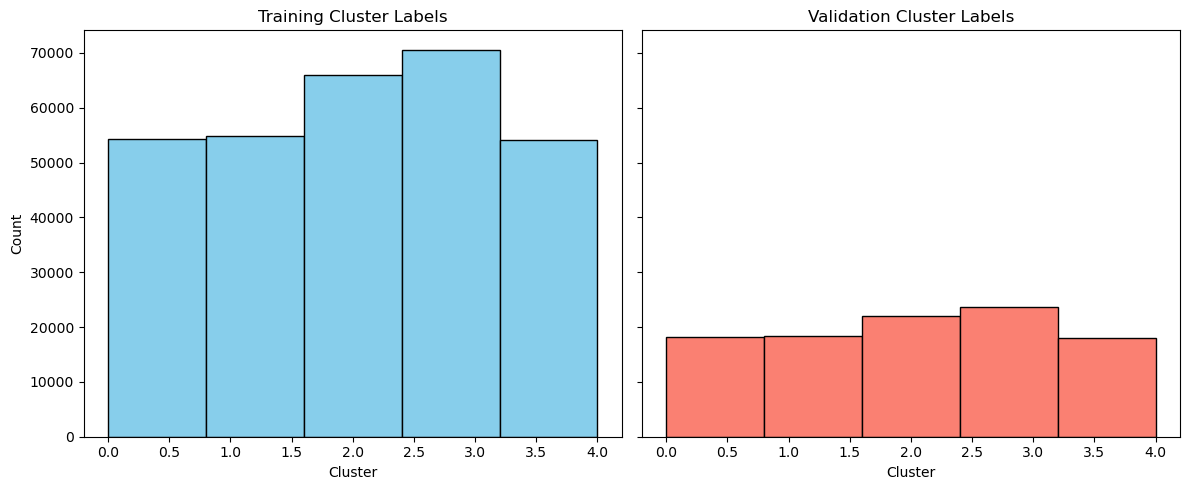

In [36]:
# Visualize labels
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Training set labels histogram
axs[0].hist(train_labels, bins=len(set(train_labels)), color='skyblue', edgecolor='black')
axs[0].set_title('Training Cluster Labels')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')

# Validation set labels histogram
axs[1].hist(val_labels, bins=len(set(val_labels)), color='salmon', edgecolor='black')
axs[1].set_title('Validation Cluster Labels')
axs[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

# 
    Clustering Evaluation Metrics:
  -     Silhouette Score: Measures how well-separated and well-formed the clusters are. Higher values are better.
  -     Davies-Bouldin Score: Measures the compactness and separation of clusters. Lower values are better.
  -     Inertia: Measures how close the points are to their assigned cluster centroids. Lower values are better.
  

# Approach
    We will use inertia to select the number of clusters (via elbow plot), and use silhouette / Davies-Bouldin to evaluate clustering quality.

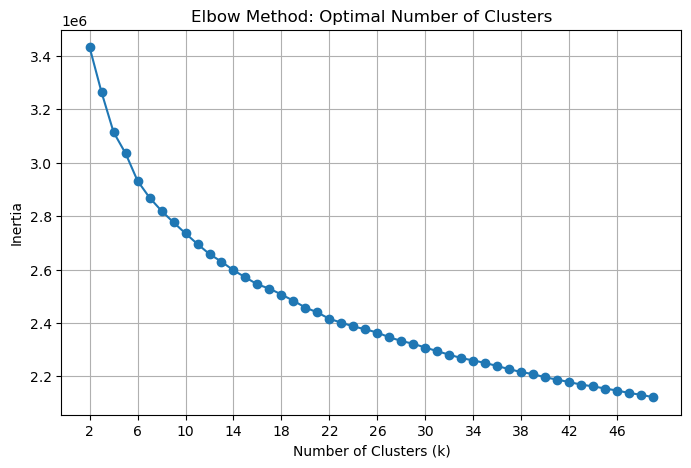

In [37]:
## Use Elbow plot to visualize the baest number of clusters to use
# use inertia as the measurement criteris

# Transform the training data once using your pipeline's preprocessor
X_train_transformed = preprocessor.fit_transform(X_train_untransformed)

# Now run the Elbow method on the transformed data
k_values = range(2, 50)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_train_transformed)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(2, len(k_values), 4))
plt.grid(True)
plt.show()

# Elbow cluster analysis to determine optimal number of clusters
    There is a trade off: we can increase number of clusters to get reduced inertia (better clustering quality), however interpretation 
    for business decisions becomes difficult.

    We note that at 6 cluster, inertia is about 2.94, which is about 38% higher than the lowest inertia (highest accuracy) attained by 50 clusters.

    We accept this accuracy, and will choose 6 as the optimal cluster size.

    Now, let us fit to 6 clusters

In [38]:
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', KMeans(n_clusters=6, random_state=RANDOM_STATE))
])
clustering_pipeline.fit(X_train_untransformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['recency', 'frequency',
                                                   'monetary',
                                                   'customer_lifetime_value',
                                                   'customer_lifespan',
                                                   'total_transactions',
                                                   'avg_discount_used', 'age',
                                                   'online_purchases',
                                                   'in_store_purchases']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low']]))]),
                                                  ['app_usage',
                                                   'social_media_engagement',
                                                   'income_bracket',
                                                   'promotion_effectiveness']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['loyalty_program'])])),
                ('clustering', KMeans(n_clusters=6, random_state=42))])

In [39]:
#get cluster labels
train_labels = clustering_pipeline.predict(X_train_untransformed)
val_labels = clustering_pipeline.predict(X_val_untransformed)

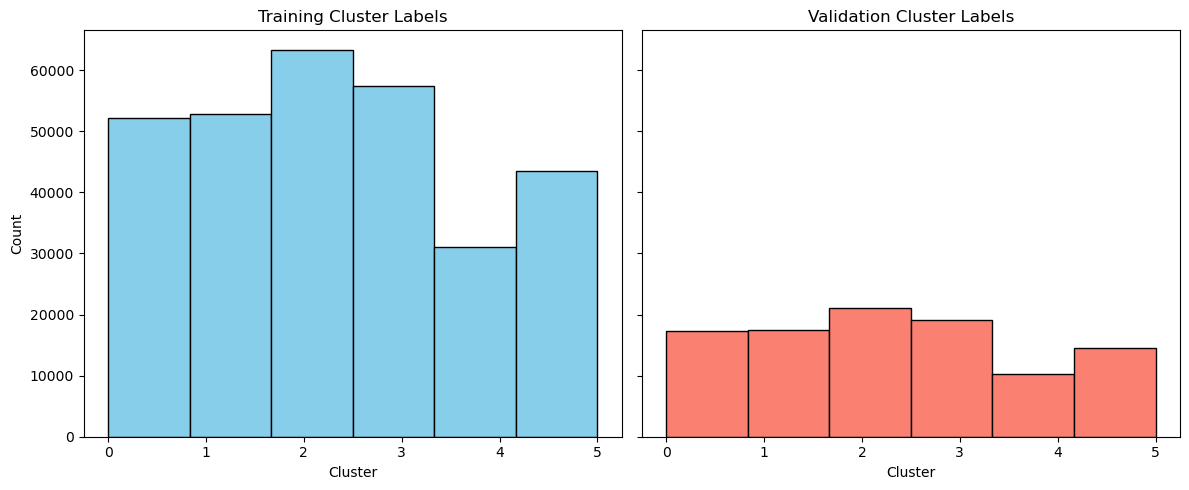

In [40]:
# Visualize labels
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Training set labels histogram
axs[0].hist(train_labels, bins=len(set(train_labels)), color='skyblue', edgecolor='black')
axs[0].set_title('Training Cluster Labels')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')

# Validation set labels histogram
axs[1].hist(val_labels, bins=len(set(val_labels)), color='salmon', edgecolor='black')
axs[1].set_title('Validation Cluster Labels')
axs[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

In [42]:
# ============================
# Clustering Evaluation: Evaluate clustering quality using metrics
# ============================
print(f"\nClustering Evaluation Metrics:")

# Inertia (within-cluster sum of squares), already calculated by pipeline
train_inertia = clustering_pipeline.named_steps['clustering'].inertia_
print(f"\nTraining Inertia: {train_inertia:.0f}")

# # Now, let us transform the datasets for feeding into metrics evaluation
# X_train_transformed = preprocessor.transform(X_train_untransformed)
# X_val_transformed = preprocessor.transform(X_val_untransformed)

# # Now predict the cluster labels using the clustering step of the pipeline
# train_labels = clustering_pipeline.named_steps['clustering'].predict(X_train_transformed)
# val_labels = clustering_pipeline.named_steps['clustering'].predict(X_val_transformed)

# # Now calculate the silhouette score using the transformed data
# train_silhouette_score = silhouette_score(X_train_transformed, train_labels)
# val_silhouette_score = silhouette_score(X_val_transformed, val_labels)

# print(f"Training Silhouette Score:        {train_silhouette_score:.3f}")
# print(f"Validation Silhouette Score:      {val_silhouette_score:.3f}")

# train_davies_bouldin_score = davies_bouldin_score(X_train_transformed, train_labels)
# val_davies_bouldin_score = davies_bouldin_score(X_val_transformed, val_labels)
# print(f"\nTraining Davies-Bouldin Score:    {train_davies_bouldin_score:.3f}")
# print(f"Validation Davies-Bouldin Score:  {val_davies_bouldin_score:.3f}")


Clustering Evaluation Metrics:

Training Inertia: 2932241


In [43]:
# Get the centroids from the KMeans model in the pipeline, 
# cetroids represent the mean values of the features for each cluster.

centroids = clustering_pipeline.named_steps['clustering'].cluster_centers_
print(f"Cluster Centroids:\n{centroids}")

Cluster Centroids:
[[ 1.21262222e-02 -5.66873042e-01 -2.12642104e-02 -3.59520299e-01
   4.76409046e-01 -9.39296757e-01  9.03710023e-03 -1.30804458e-02
   3.33422332e-03  6.99784769e-01  1.00278552e+00  1.00420709e+00
   9.95043704e-01  9.91950821e-01  5.01143022e-01]
 [ 6.46711847e-03 -5.66950731e-01  2.68580631e-03 -3.57405767e-01
   4.81550242e-01  9.61592011e-01 -2.71099158e-02  1.90298045e-02
  -2.42922836e-02  6.48927924e-01  1.00587444e+00  9.86810938e-01
   1.01804021e+00  1.00680298e+00  5.03098293e-01]
 [-7.19454590e-03 -5.70626903e-01 -3.39768329e-04 -3.55145105e-01
   5.07605848e-01 -2.84891750e-02  5.63699683e-03 -1.30463256e-02
   1.09436005e-02 -1.06239494e+00  9.97679082e-01  9.94979238e-01
   9.99889480e-01  9.98436933e-01  4.97150165e-01]
 [-3.63623301e-03 -5.71801878e-01  1.48529044e-02 -5.38759584e-01
  -1.42903008e+00  1.56395159e-03  9.49495754e-03 -4.20030668e-04
   2.80347097e-03 -4.70198401e-02  1.00167492e+00  1.00383837e+00
   9.97662084e-01  9.99214879e-01  4

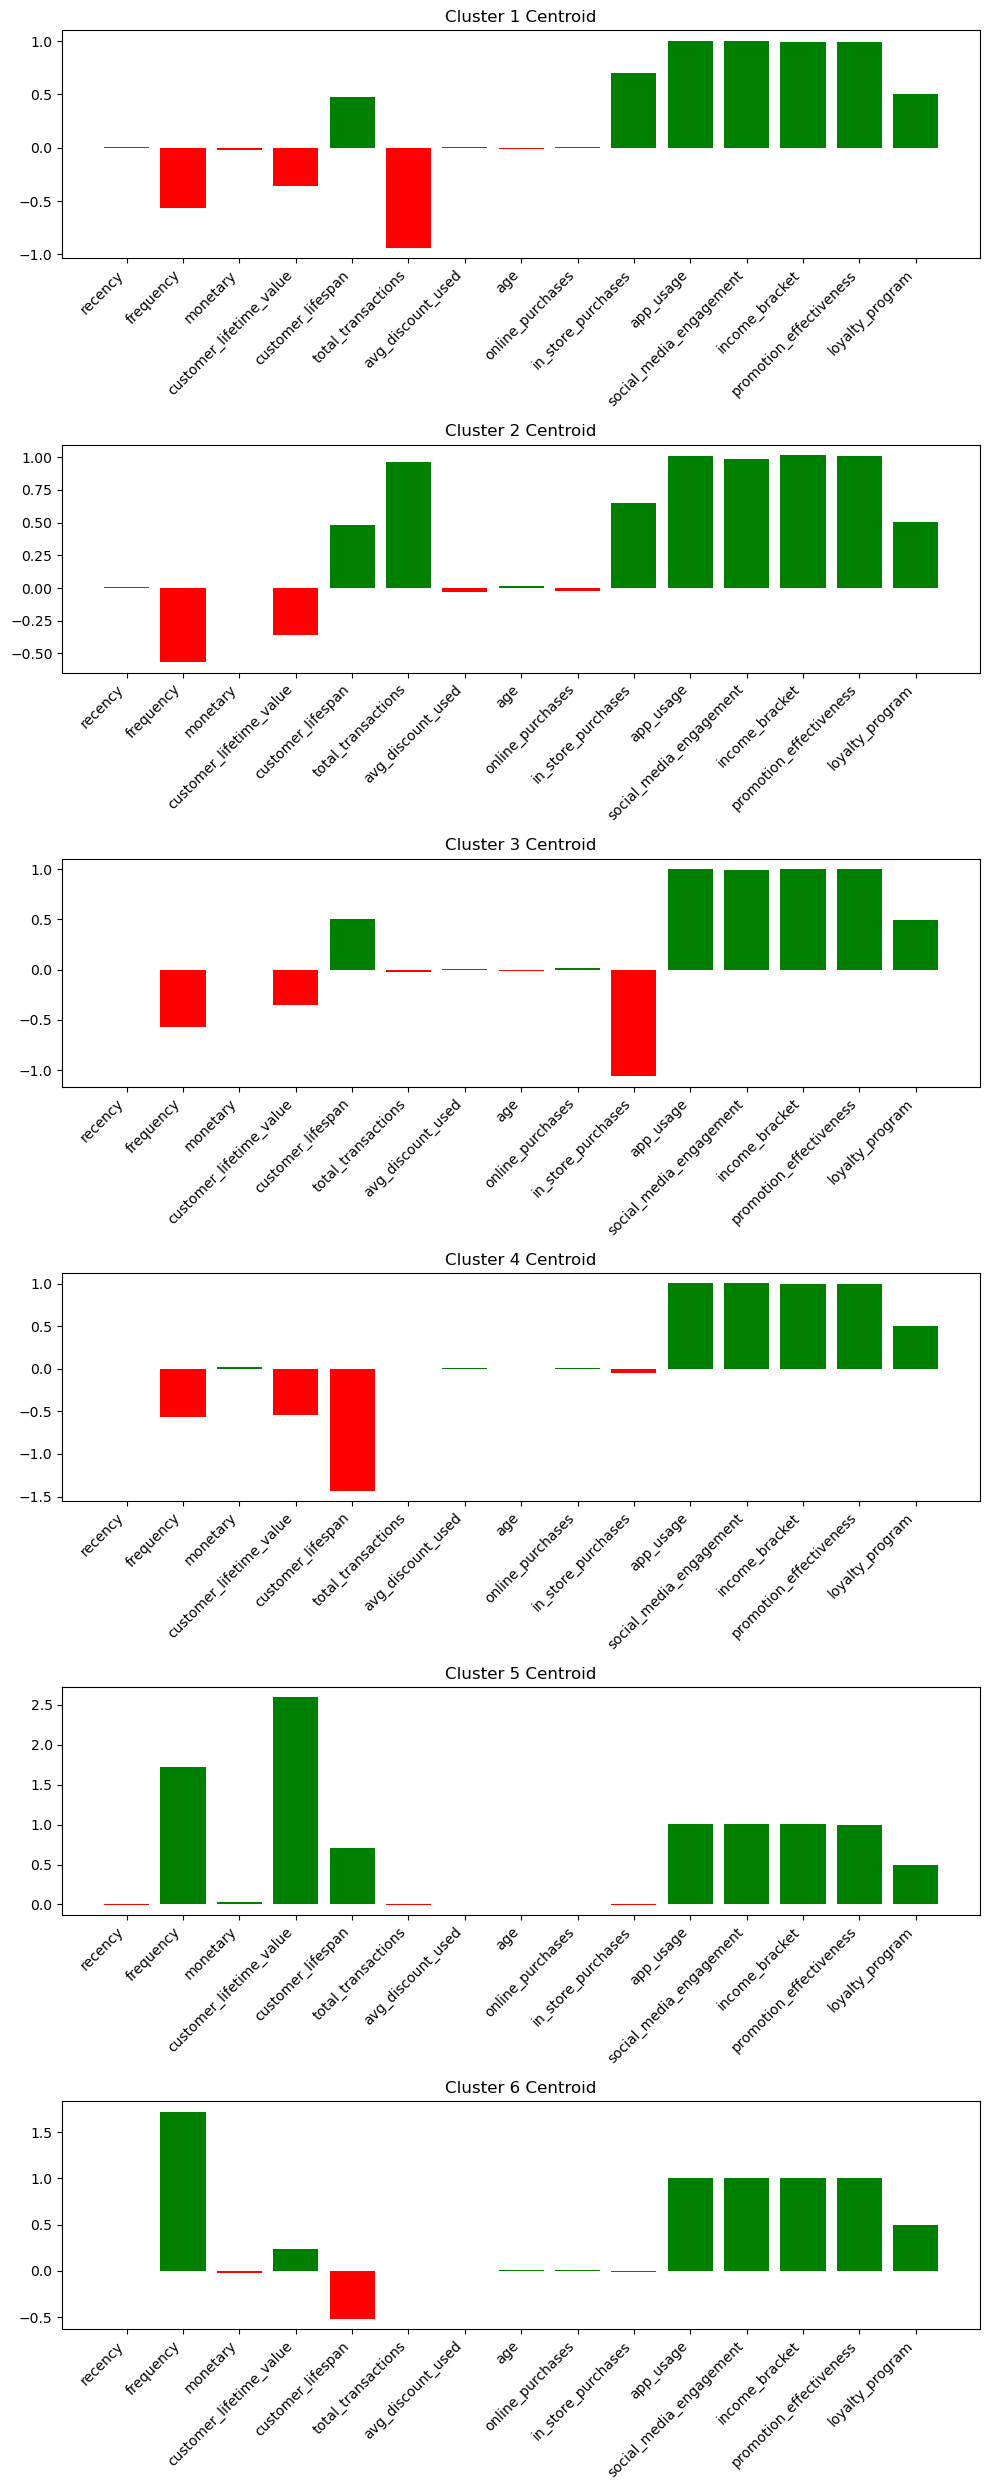

In [44]:
#Lets visualize the centroids to see which features are 'signature or salient' features of each cluster
#this can help us give names to our clustered segments
centroids_df = pd.DataFrame(centroids, columns=numeric_features + ordinal_cat_features + nominal_cat_features)

fig, axes = plt.subplots(6, 1, figsize=(10, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each cluster's centroid in a separate subplot
for i in range(6):  # 6 clusters
    # Color bars: green for positive values, red for negative values
    colors = ['green' if value > 0 else 'red' for value in centroids_df.iloc[i]]

    axes[i].bar(centroids_df.columns, centroids_df.iloc[i], color=colors)
    axes[i].set_title(f'Cluster {i+1} Centroid')
    axes[i].set_xticklabels(centroids_df.columns, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

# Do
    1. Silhoutte visualization
    2. Interpret metrics cluster quality
    3. PCA visualization
    4. tsne visualization
    

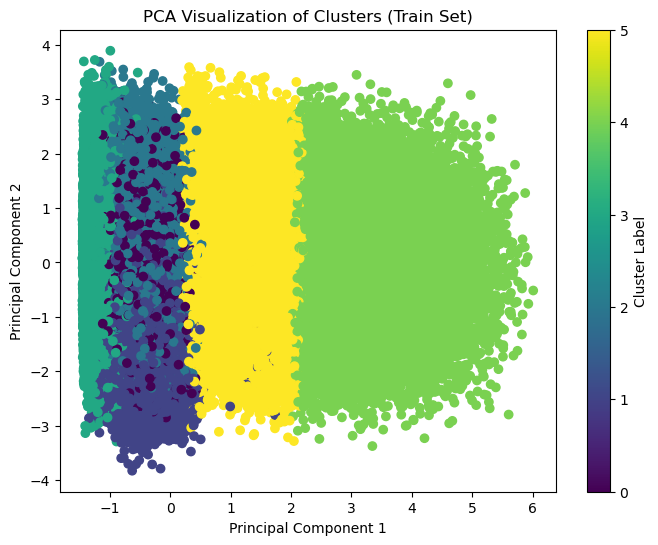

In [45]:
# PCA Cardinality, and visulzaiton of our clusters
# PCA Visualization (Only for Train Set)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(clustering_pipeline.named_steps['preprocessor'].transform(X_train_untransformed))

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels, cmap='viridis')
plt.title("PCA Visualization of Clusters (Train Set)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

# PCA visualization comments
    Clusters 4, 5, 3 are rather internally coherent, and cleanly separated. Clusters 0, 1 and 2 not so much. 
    But even though sepraration is not clearly marked, even for clusters 2 and 1, there is rather separate regions.

    We accept these results as good for a first cut. A nest step, would rationalize feature sets, and introduce higher univariate distribution through a more judicious data collection exercise into the clustering exercise.

# Now, Lets to GMM

    GMM uses a K mixture of Gaussians to distributionalize the data. Through the EM iterative method, mu, covariance sigma and weight of each gaussian is calcuated, givin a clustering labels (or rather probability of each cluster k) for each data point.

    K-means hard classifies a data point into a cluster; GMM uses a soft classification in that each data point is assigned a probability of belonging to each cluster; arg max gives the assigned cluster.



# GMM Approach

    PCA transformed training data. PCA = 2 (for visualization)
    kmeans and GMM PCA'ed training data. get cluster labels from each
    scatterplot the pca x y hued on kmeans and gmm side by sude plots
    We will use 6 clusters as determined by our elbow selection earlier

In [ ]:
X_train_untransformed

In [ ]:
X_train_transformed

In [47]:
summarize_dataframe(X_temp_untransformed)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,recency,int64,0,400000,731
1,frequency,int64,0,400000,4
2,monetary,float64,0,400000,329176
3,customer_lifetime_value,float64,0,400000,400000
4,customer_lifespan,float64,0,400000,10
5,total_transactions,int64,0,400000,99
6,avg_discount_used,float64,0,400000,51
7,age,int64,0,400000,62
8,online_purchases,int64,0,400000,100
9,in_store_purchases,int64,0,400000,100


In [53]:
X_train_transformed = preprocessor.fit_transform(X_train_untransformed)

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train_untransformed)

#1. for scatter plot visualization, not for predicting
pca = PCA(n_components=2, random_state = RANDOM_STATE)
X_pcaed = pca.fit_transform(X_train_transformed)

#2.
kmeans_labels = KMeans(n_clusters=6, random_state=RANDOM_STATE).fit_predict(X_train_transformed)

#3.
gmm_labels = GaussianMixture(n_components=6, random_state=RANDOM_STATE).fit_predict(X_train_transformed)

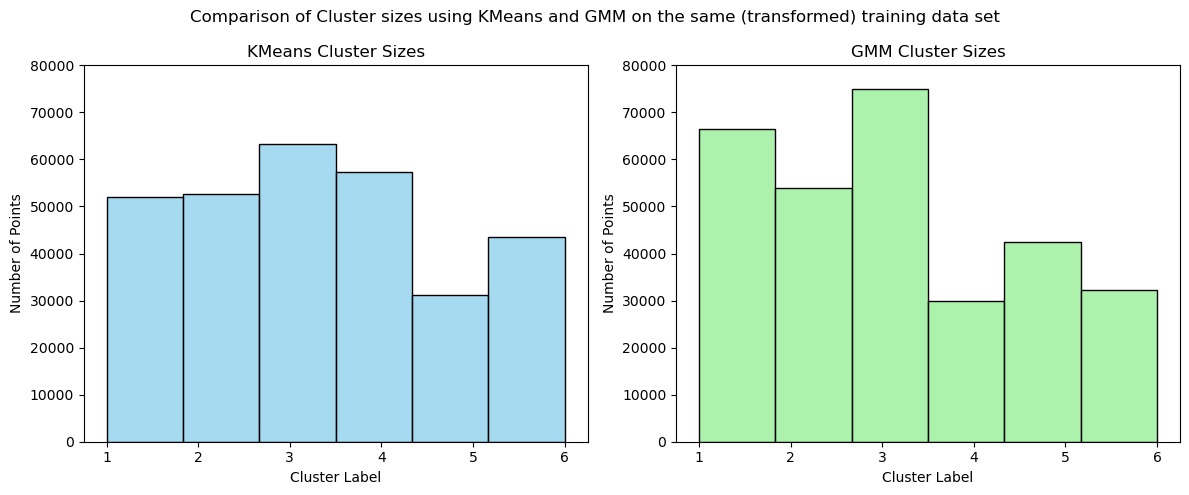

In [65]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(kmeans_labels+1, kde=False, bins=len(np.unique(kmeans_labels)), color='skyblue')
plt.ylim(0,80000)
plt.title("KMeans Cluster Sizes")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")

plt.subplot(1, 2, 2)
sns.histplot(gmm_labels+1, kde=False, bins=len(np.unique(gmm_labels)), color='lightgreen')
plt.ylim(0,80000)
plt.title("GMM Cluster Sizes")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")

plt.suptitle("Comparison of Cluster sizes using KMeans and GMM on the same (transformed) training data set")

plt.tight_layout()
plt.show()

# KMeans and GMM comparison
    Clusters 1, 2, 3, and 5 have higher number of assigned samples in GMM relative to Kmeans
    Clusters 4, and 6 have higher assignments in Kmeans versus GMM

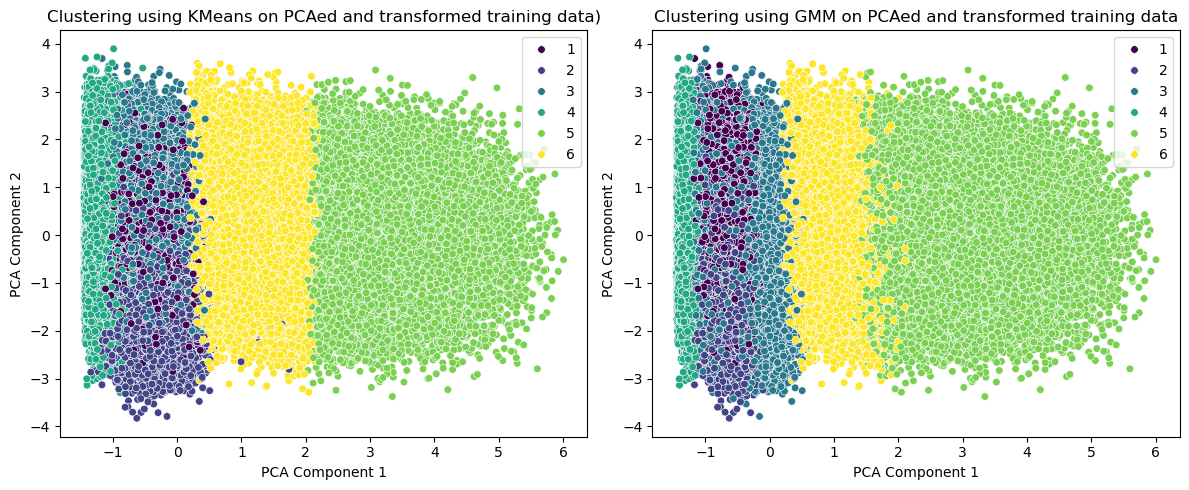

In [69]:
#scatter plot PCAed X_train_transformed

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pcaed[:, 0], y=X_pcaed[:, 1], hue=kmeans_labels+1, palette='viridis', s=30)
plt.title("Clustering using KMeans on PCAed and transformed training data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pcaed[:, 0], y=X_pcaed[:, 1], hue=gmm_labels+1, palette='viridis', s=30)
plt.title("Clustering using GMM on PCAed and transformed training data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

# KMeans versus GMM performance of clustering
    Clusters 1, 2, and 3 that have poor separation in K-Means have better quality cluster separation using GMM

# Now we will extract customer segments using GMM's means 
    Kmeans has cluster centroids, GMM has cluster means

In [74]:
gmm = GaussianMixture(n_components=6, random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(X_train_transformed)
gmm_means = gmm.means_

gmm_means_df = pd.DataFrame(gmm_means, columns=numeric_features + ordinal_cat_features + nominal_cat_features)

In [75]:
gmm_means_df

,recency,frequency,monetary,customer_lifetime_value,customer_lifespan,total_transactions,avg_discount_used,age,online_purchases,in_store_purchases,app_usage,social_media_engagement,income_bracket,promotion_effectiveness,loyalty_program
0,0.002347,-0.672457,-0.007907,-0.453001,0.392285,-0.741137,0.001228,-0.006910,-0.000258,0.004634,1.003956,1.003992,0.999986,0.994815,0.502103
1,-0.001362,-0.672225,0.004718,-0.450286,0.398267,0.927253,-0.006705,-0.005417,-0.006563,0.002458,1.003503,0.991606,1.006742,0.994892,0.499854
2,0.006158,-0.368454,0.000593,-0.259830,0.000985,0.005352,0.003461,0.002558,-0.000849,-0.000026,0.999106,0.992715,1.002068,1.002628,0.498239
3,-0.008275,-0.672834,0.004471,-0.571848,-1.604577,-0.008529,-0.000724,0.001803,0.006362,-0.000700,1.000329,1.005782,1.000691,1.007825,0.498439
4,-0.007636,1.722230,0.006766,2.053576,0.485738,-0.000519,-0.003815,0.002178,0.004171,-0.004360,1.002542,1.002332,1.002800,0.994694,0.496795
5,0.001286,1.722230,-0.006629,-0.014286,-0.722265,-0.004047,0.006911,0.013627,0.001946,-0.007474,1.003338,1.004904,0.999717,1.003510,0.495787


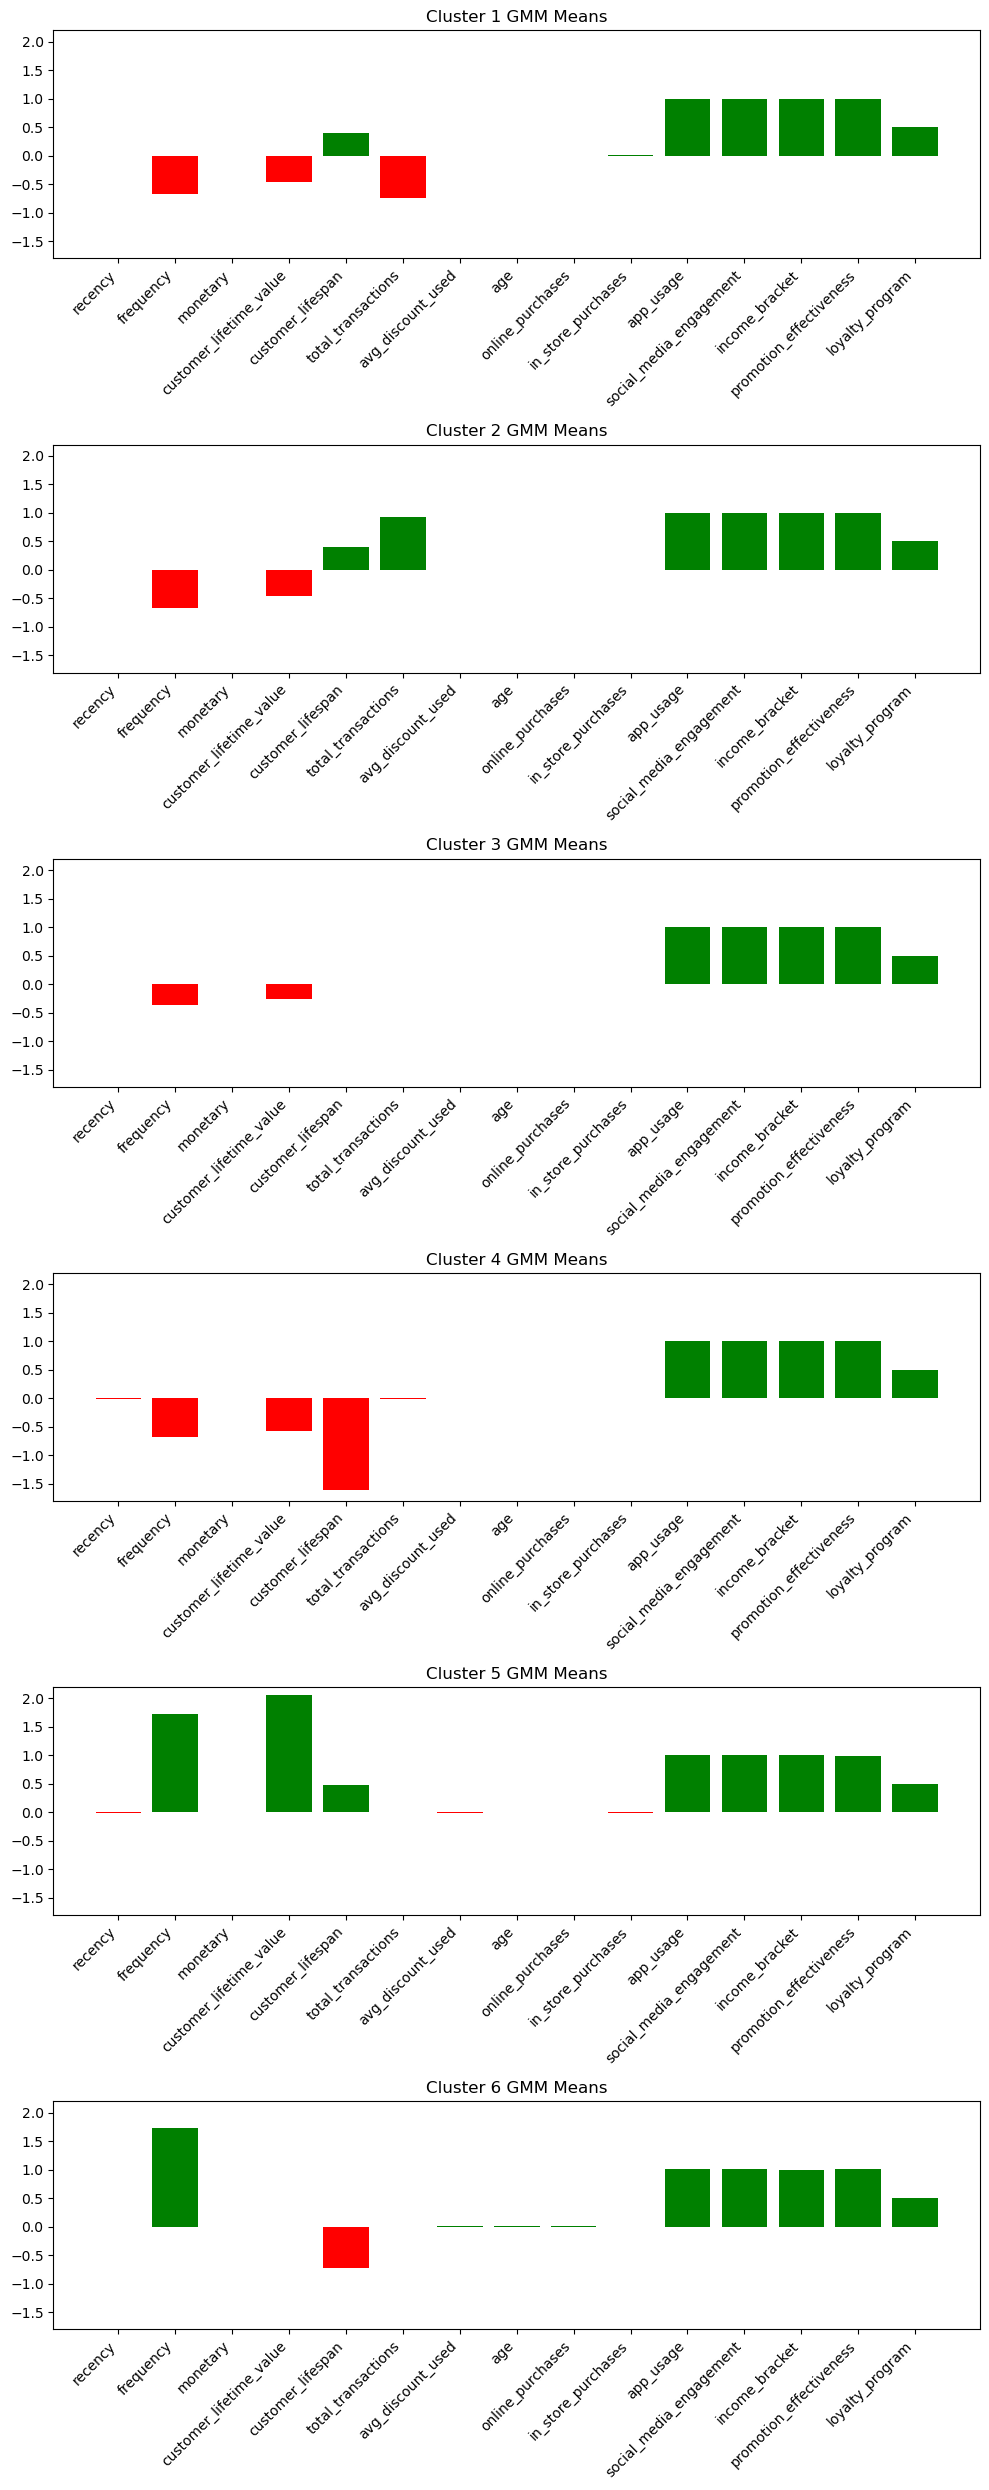

In [80]:


fig, axes = plt.subplots(6, 1, figsize=(10, 25))

axes = axes.flatten()

for i in range(6):
    colors = ['green' if value > 0 else 'red' for value in gmm_means_df.iloc[i]]

    axes[i].bar(gmm_means_df.columns, gmm_means_df.iloc[i], color=colors)
    axes[i].set_title(f'Cluster {i+1} GMM Means')
    axes[i].set_xticklabels(gmm_means_df.columns, rotation=45, ha='right')
    axes[i].set_ylim(-1.8, 2.2)

plt.tight_layout()
plt.show()

# 
    GMM predicted segments have weak resoution that is there is not much feature value variation across segments, of course because the GMM model used 2 PCAs and those 2 PCAs were meant for visualization.

    We looked at GMM's segments just out of curiosity. In practice, they do not mean much, because our GMM model was fitted on PCA data.

    As a next step, one would run GMM using 6 clusters on the FULL X_train_transformed, that for a 300K row data set is more than our machine can afford, so we will stop here. 